In [1]:
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.1+cpu'

<center>

<img  src= ..\images\01_a_pytorch_workflow.png>
</center>

### Data (preparing and loading)

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.
Note that th elinear regression in this case only has one varibale x1 <br>
Later in this turorial we will use the house pricing data to predcit the house price based only one feature which is the house size

In [2]:
# Create the known params
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
# unsqueeze to make the shape (50, 1) instead of 50
y = weight * X + bias
print(f"{X[:10]} \n\n {y[:10]}")
# print(X.shape)

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) 

 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


We'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our X and y tensors.

Note: When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it generalizes to unseen examples.

In [3]:
#  Create train / test splits
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualize the data

In [4]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14});

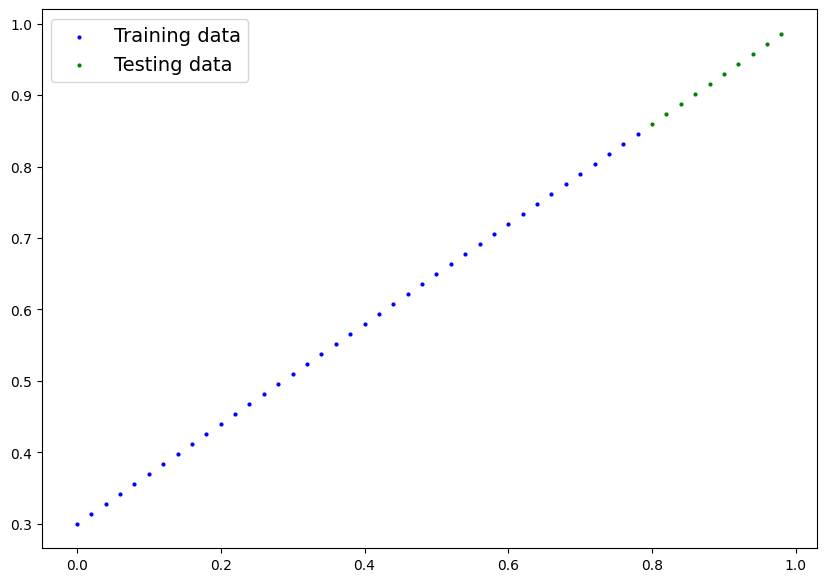

In [5]:
plot_predictions()

### Let's build a model : 
let's build a model to use the blue dots to predict the green dots by replicating a regular linear regression model usin PyTorch

In [6]:
class MyLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, dtype=torch.float32), requires_grad=True
        )
        # nn.Parameter is a kind of Tensor that is to be considered a module parameter
        self.bias = nn.Parameter(
            torch.randn(1, dtype=torch.float32), requires_grad=True
        )
        # We will start with a random weights and bias that will also be adjusted when the model learns
        # print(self.weights, self.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Define the forward pass through the neural network."""
        return self.weights * x + self.bias  # linear regression formula (y = m*x + b)

### Forward pass....What is it exactly ?
#### What does it do ? :
- Defines the forward pass : The forward method defines how the input data flows through the layers of the neural network to produce the output.
It specifies the computation graph that transforms the input into the output.

- The Automatic Differentiation: PyTorch uses dynamic computational graphs for automatic differentiation. The forward pass is responsible for constructing this graph.
The graph is later used during the backward pass to compute gradients for the parameters, enabling gradient-based optimization.

#### How does it do it ? :
- Parameterized Layers: Neural network layers (such as linear layers, activation functions, etc.) are defined as parameters in the __init__ method.
These layers are instances of PyTorch's nn.Module classes.
- Forward Computation: In the forward method, you specify how the input data should pass through these layers.
You apply the layers to the input data, often using functions provided by PyTorch's nn module (e.g., nn.Linear, nn.ReLU, etc.).
- Return Output: The final result of the forward pass is the output of the model.
This output is typically the prediction made by the model based on the input data.
- Automatic Differentiation: During the forward pass, PyTorch automatically tracks operations on tensors.
This tracking is used to construct a dynamic computation graph.
- Backward Pass: The constructed computation graph is later utilized during the backward pass.
Gradients are computed for the model parameters with respect to a specified loss function.
These gradients are then used to update the model parameters through optimization algorithms like stochastic gradient descent (SGD).

### PyTorch model building essentials :
PyTorch has 4 essential modules you can use to create almost any kind of neural network you can imagine : 
- torch.nn 
- torch.optim
- torch.utils.data.Dataset 
- torch.utils.data.DataLoader. 



In [7]:
torch.manual_seed(42)
my_model = MyLinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(my_model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
my_model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using torch.inference_mode()

We can pass it the test data X_test to see how closely it predicts y_test.

When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

In [9]:
with torch.inference_mode():
    """context manager like torch.no_grad()
    torch.inference_mode() turns off a bunch of things (like gradient tracking,
    which is necessary for training but not for inference) to make forward-passes
    (data going through the forward() method) faster."""
    y_preds = my_model(X_test)
    print(y_preds[:10])

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


In [10]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


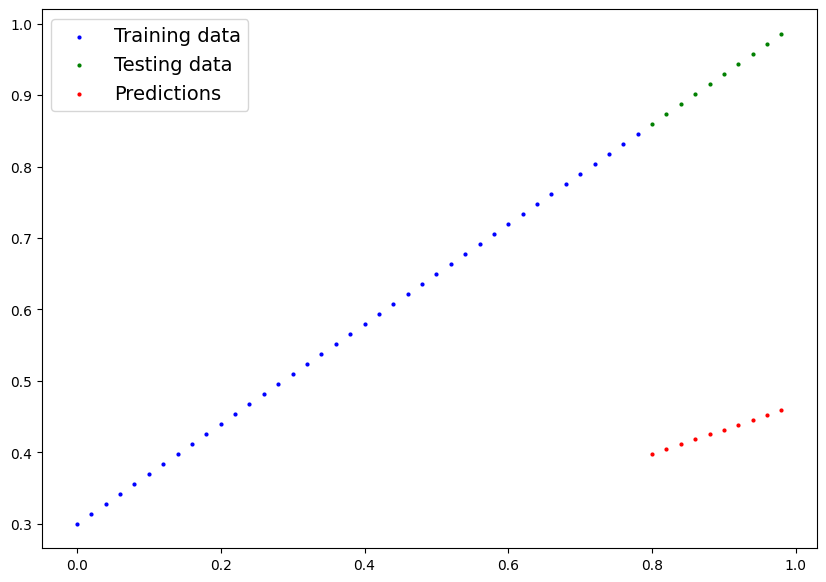

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

The predictions suck...which makes sense cause the model is initialized with random parameters <br>
We gotta enhance them !

### Let's train the model :

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a loss function as well as an optimizer.

In [13]:
# Create the loss function
# MAE loss is same as L1Loss
loss_fn = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(
    params=my_model.parameters(), lr=0.01  # parameters of target model to optimize
)  # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

C:\Users\PC CABA DZ\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 168

# track training and testing loss values
train_losses = []
test_losses = []
epoch_count = []

# THE TRAINING LOOP
for epoch in range(epochs):
    # put the model in training mode
    my_model.train()

    # forward pass the training data
    y_pred = my_model(X_train)
    # y_pred = my_model.forward(X_train)

    # calculate the loss function
    train_loss = loss_fn(y_pred, y_train)

    #  zero grad the optimizer
    optimizer.zero_grad()

    # loss backwards, back propagation

    train_loss.backward()

    # progress the optimizer
    optimizer.step()
    # put the model tot est
    my_model.eval()

    with torch.inference_mode():
        # forward pass the testing data
        test_pred = my_model(X_test)

        # calculate the loss on the testing data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        epoch_count.append(epoch)
        train_losses.append(train_loss.detach().numpy())
        test_losses.append(test_loss.detach().numpy())

        print(
            f"Epoch : {epoch}\n\tMAE Train Loss (L1 Loss) --> {train_loss}\n\tMAE Test Loss (L1 Loss)  --> {test_loss} \n"
        )

Epoch : 0
	MAE Train Loss (L1 Loss) --> 0.31288138031959534
	MAE Test Loss (L1 Loss)  --> 0.48106518387794495 

Epoch : 1
	MAE Train Loss (L1 Loss) --> 0.3013603389263153
	MAE Test Loss (L1 Loss)  --> 0.4675942063331604 

Epoch : 2
	MAE Train Loss (L1 Loss) --> 0.28983935713768005
	MAE Test Loss (L1 Loss)  --> 0.4541231691837311 

Epoch : 3
	MAE Train Loss (L1 Loss) --> 0.2783183455467224
	MAE Test Loss (L1 Loss)  --> 0.44065219163894653 

Epoch : 4
	MAE Train Loss (L1 Loss) --> 0.26679736375808716
	MAE Test Loss (L1 Loss)  --> 0.4271811842918396 

Epoch : 5
	MAE Train Loss (L1 Loss) --> 0.2552763521671295
	MAE Test Loss (L1 Loss)  --> 0.41371020674705505 

Epoch : 6
	MAE Train Loss (L1 Loss) --> 0.24375534057617188
	MAE Test Loss (L1 Loss)  --> 0.40023916959762573 

Epoch : 7
	MAE Train Loss (L1 Loss) --> 0.23223432898521423
	MAE Test Loss (L1 Loss)  --> 0.3867681920528412 

Epoch : 8
	MAE Train Loss (L1 Loss) --> 0.22071333229541779
	MAE Test Loss (L1 Loss)  --> 0.37329721450805664 


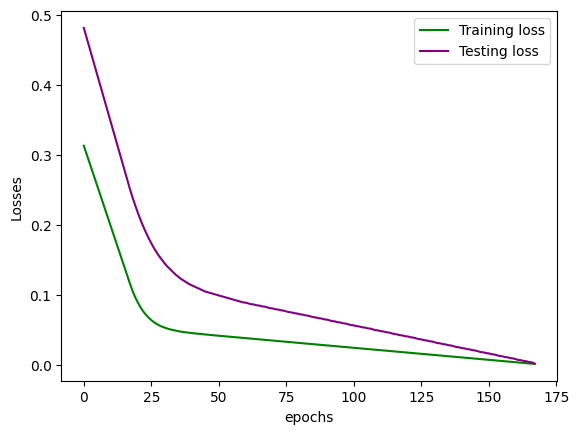

In [15]:
# Plot the train_loss and test_loss
import matplotlib.pyplot as plt

plt.plot(epoch_count, train_losses, label="Training loss", c="green")
plt.plot(epoch_count, test_losses, label="Testing loss", c="purple")
plt.xlabel("epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

In [16]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(my_model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6947])), ('bias', tensor([0.3028]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### Trying inference ( make predictions with a tained PyTorch Model)
There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (model.eval()).
2. Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only)

In [17]:
# Trying inference ( make predictions with a tained PyTorch Model)
my_model.eval()
with torch.inference_mode():
    my_model.to(device="cpu")
    y_preds = my_model(X_test)

y_preds

tensor([[0.8586],
        [0.8725],
        [0.8864],
        [0.9003],
        [0.9142],
        [0.9281],
        [0.9420],
        [0.9559],
        [0.9698],
        [0.9837]])

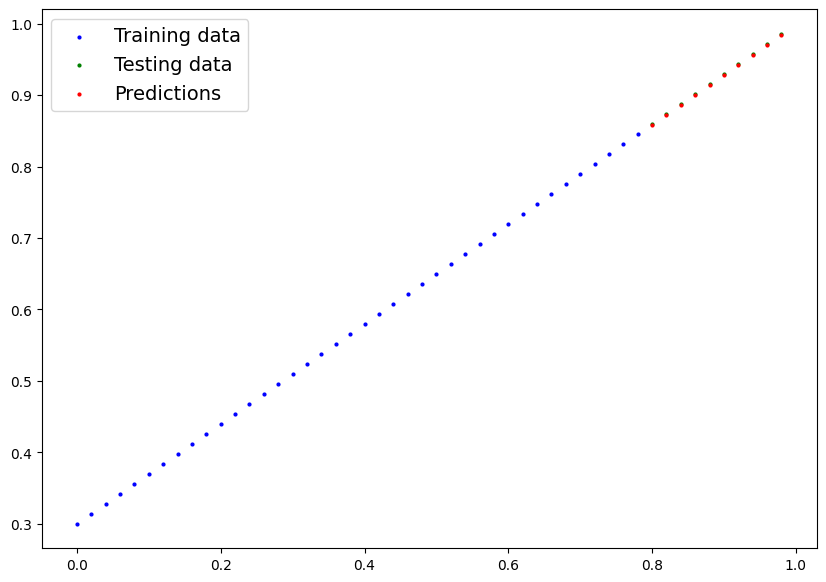

In [18]:
plot_predictions(predictions=y_preds)

PERFECT....

Now , let's save the model : 


In [19]:
from pathlib import Path

# 1. Create my models directory
MODEL_PATH = Path("my_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path

MODEL_NAME = "00.pt_linear_regression_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the modelstate dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=my_model.state_dict(), f=MODEL_SAVE_PATH)
print("Model saved successfully !")

Saving model to : my_models\00.pt_linear_regression_model.pth
Model saved successfully !


### Loading the model 

In [20]:
# Instanciate a model
my_model_loaded = MyLinearRegressionModel()

# Load the state dict of my previous saved model into this one
my_model_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
my_model_loaded.eval()
with torch.inference_mode():
    my_model_loaded.to(device="cpu")
    loaded_y_preds = my_model_loaded(X_test)


print(y_preds == loaded_y_preds)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])
